<a href="https://colab.research.google.com/github/devyadav11/ML_tryouts/blob/main/EfficientNetV2S_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================
# 1. Install & Imports
# ==========================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile # Import zipfile module

# ==========================
# 2. Dataset Loading
# ==========================

# Extract the dataset from the zip file
zip_path = "/content/analmoly detection dataset-20250819T072424Z-1-001.zip"
extract_path = "/content/analmoly detection dataset" # Define extraction path

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")

dataset_root = extract_path  # adjust path if needed

img_size = (224, 224)   # EfficientNetV2 expects 224x224
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    dataset_root,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = keras.utils.image_dataset_from_directory(
    dataset_root,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

# ==========================
# 3. Data Augmentation
# ==========================
# data_augmentation = keras.Sequential([
#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
# ])

# ==========================
# 4. Model: EfficientNetV2
# ==========================
base_model = keras.applications.EfficientNetV2S(
    input_shape=img_size + (3,),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # freeze backbone for transfer learning

inputs = keras.Input(shape=img_size + (3,))
# x = data_augmentation(inputs)
x = keras.applications.efficientnet_v2.preprocess_input(inputs)  # preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# ==========================
# 5. Compile
# ==========================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ==========================
# 6. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# ==========================
# 7. Fine-tuning (optional)
# ==========================
# Unfreeze some top layers of EfficientNetV2 for extra accuracy
base_model.trainable = True
for layer in base_model.layers[:-10]:  # freeze most, train last 50
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# ==========================
# 8. Save Model
# ==========================
model.save("efficientnetv2_defect_model.h5")

# ==========================
# 9. Evaluate
# ==========================
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")

Found 62 files belonging to 2 classes.
Using 50 files for training.
Found 62 files belonging to 2 classes.
Using 12 files for validation.
Classes: ['defect', 'non_defect']
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 106s 54s/step - accuracy: 0.6662 - loss: 0.6489 - val_accuracy: 0.5000 - val_loss: 0.6829
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.6142 - loss: 0.6732 - val_accuracy: 0.8333 - val_loss: 0.6640
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6275 - loss: 0.6434 - val_accuracy: 0.9167 - val_loss: 0.6457
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6662 - loss: 0.6379 - val_accuracy: 1.0000 - val_loss: 0.6281
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.6646 - loss: 0.6460 - val_accuracy: 1.0000 - val_loss: 0.6109
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8650 - loss: 0.5889 - val_accuracy: 1.0000 - val_loss: 0.5944
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.8413 - loss: 0.6013 - val_accuracy: 0.9167 - val_loss: 0.5787
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.7804 - loss: 0.5950 - val_accuracy: 0.9167 - val_loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 0.3772
Validation Accuracy: 1.00


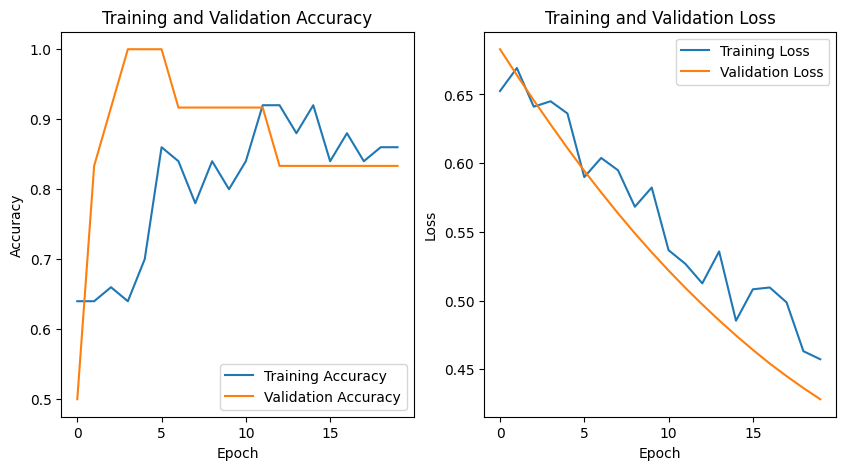

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [27]:
img_path = os.path.join('/content/analmoly detection dataset/non_defect/1_CAI_101_120_730_greencam1_2025-05-27_11_59_33-426354_750_image.jpg.jpg') # Replace with a valid test image path

# Load the image, resizing it to the target size
img = tf.keras.utils.load_img(img_path, target_size=img_size)

# Convert the loaded image to a NumPy array
img_array = tf.keras.utils.img_to_array(img)

# Expand the dimensions to create a batch of size 1
img_array = tf.expand_dims(img_array, 0) # Create a batch

In [28]:
# Load the saved model
loaded_model = keras.models.load_model("efficientnetv2_defect_model.h5")

if img_array is not None:
    # Use the loaded model to predict
    predictions = loaded_model.predict(img_array)

    # Extract the score for binary classification (sigmoid output)
    score = predictions[0][0]

    # Print the raw prediction score
    print(f"Raw prediction score: {score}")
else:
    print("Cannot perform prediction: No image was loaded.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Raw prediction score: 0.6642307639122009


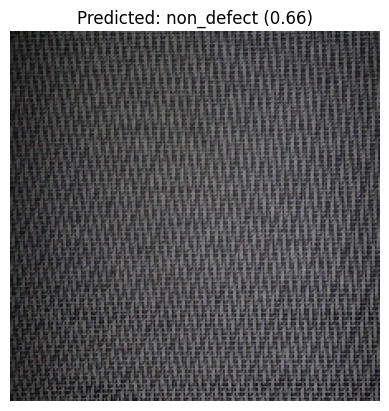

In [29]:
if img_array is not None:
    # Define a threshold for classifying the image (e.g., 0.5 for sigmoid output)
    threshold = 0.5

    # Determine the predicted class based on the score and the threshold
    if score > threshold:
        predicted_class = class_names[1] # 'non_defect'
        confidence = score
    else:
        predicted_class = class_names[0] # 'defect'
        confidence = 1 - score

    # Display the original image
    plt.figure()
    # Convert img_array back to the original image format for displaying
    # Remove the batch dimension and scale back if preprocessing involved scaling
    # In this case, preprocess_input scales, but load_img does not, so we can display directly
    # from the original loaded img if available, or un-normalize if preprocess_input was applied before this point.
    # Since preprocess_input was applied *after* data augmentation and before the base model,
    # the img_array here (before prediction) is the output of img_to_array and expand_dims,
    # which is a float array, possibly with values > 255 or < 0 due to data augmentation.
    # Let's display the original 'img' object loaded before img_to_array if possible.
    # If not, we'll try to display the un-normalized img_array, clamping values.

    # We have the original 'img' object from the previous step.
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
    plt.axis('off') # Hide axes
    plt.show()

else:
    print("Cannot classify and display image: No image was loaded.")